# Overview

Objective: Determine what drives success (as defined by visits, which is assumed to be revenue) in DC.

Yelp (visits, reviews, positivity), Instagram/FB (brand awareness), news coverage

## Yelp Insights

We seek to know what visitors at restaurants have to say about well-performing wine bars. What causes a positive experience? Who is visiting? What drives out-of-town visits? In-town visits? How are restaurant reviews trending over time? Do repeat customers exist? Where do Yelp wine bar connoseurs go? (How can we attract the right ones?)

![chart](https://data.world/api/chart/export/8b8dc69a0da693c4a134dd80d49c4851cf1b37a81753825815ae70e8b974038d.png)

tl;dr: Barcelona is killing it

In [ ]:
# import libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import csv
import nltk
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from textblob import TextBlob, Word
from sklearn.model_selection import train_test_split
import numpy as np

from sklearn.naive_bayes import MultinomialNB
from sklearn import svm, metrics
from sklearn.metrics import confusion_matrix
from sklearn.grid_search import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
% matplotlib inline

In [2]:
import codecs
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [3]:
wine = pd.read_csv('https://query.data.world/s/A2CYWTYyqnma6Y7iFOOKXDuKwZreZz')

In [4]:
wine.head()

,rest_name,username,review,stars,date,location
0,La Jambe,/user_details?userid=GBjdziANdkk29jjwOBj5ow,This review is massively overdue (I don't writ...,5,8/25/2017,"Washington, DC"
1,La Jambe,/user_details?userid=X3Ki2Z6JTn9gbuz23NO3kg,My friends and I were looking for a good happy...,4,9/25/2017,"Washington, DC"
2,La Jambe,/user_details?userid=dOYJX2FBw5FXDBwXZZoq7A,Elegant and intimate - La Jambe has an unexpec...,4,8/11/2017,"Washington, DC"
3,La Jambe,/user_details?userid=ZaJ6zPDAc7YaDTE2QEBGPA,This place is really special. If your in the a...,5,7/23/2017,"Red Bank, NJ"
4,La Jambe,/user_details?userid=mz8Q8yEOkgjaISIqzUSHLg,Hooray for happy hour! $5 for delicious wines?...,4,7/10/2017,"Washington, DC"


# Repeat users analysis

In [5]:
wine.shape

(4934, 6)

In [6]:
# what percent of reviews are by repeat users?
(1 - float(wine.username.nunique()) / wine.shape[0])*100

16.396432914471013

In [7]:
# how many restaraunts
wine.rest_name.nunique()

19

In [8]:
# get repeat people
repeats = wine.username.duplicated()

In [9]:
repeats

0       False
1       False
2       False
3       False
4       False
5       False
6       False
7       False
8       False
9       False
10      False
11      False
12      False
13      False
14      False
15      False
16      False
17      False
18      False
19      False
20      False
21      False
22      False
23      False
24      False
25      False
26      False
27      False
28      False
29      False
        ...  
4904    False
4905     True
4906     True
4907    False
4908    False
4909    False
4910    False
4911     True
4912    False
4913    False
4914     True
4915    False
4916    False
4917     True
4918     True
4919    False
4920    False
4921    False
4922     True
4923    False
4924    False
4925    False
4926    False
4927    False
4928    False
4929    False
4930    False
4931    False
4932    False
4933     True
Name: username, dtype: bool

In [10]:
# get reviews from unique people
wine[repeats]

,rest_name,username,review,stars,date,location
68,La Jambe,/user_details?userid=-9YZc25iHMluMxf949822Q,This place is a delight. Wonderful charcuterie...,5,6/30/2016,"Washington, DC"
108,ENO Wine Bar,/user_details?userid=UrkD6iinGp26KvsWi8c7pQ,The flights of wine are a unique idea and they...,3,1/15/2014,"Arlington, VA"
127,ENO Wine Bar,/user_details?userid=UrkD6iinGp26KvsWi8c7pQ,Honestly one of the best places I've been to i...,5,11/18/2013,"Alameda, CA"
140,Bin 1301 Wine Bar,/user_details?userid=KiyPUvmz2HDmZvP8yiiuxw,We came here on a rainy day that also happened...,4,5/9/2017,"Washington, DC"
189,La Jambe,/user_details?userid=GBjdziANdkk29jjwOBj5ow,My friends and I were looking for a good happy...,4,9/25/2017,"Washington, DC"
190,La Jambe,/user_details?userid=X3Ki2Z6JTn9gbuz23NO3kg,Elegant and intimate - La Jambe has an unexpec...,4,8/11/2017,"Washington, DC"
191,La Jambe,/user_details?userid=dOYJX2FBw5FXDBwXZZoq7A,This place is really special. If your in the a...,5,7/23/2017,"Red Bank, NJ"
192,La Jambe,/user_details?userid=ZaJ6zPDAc7YaDTE2QEBGPA,Hooray for happy hour! $5 for delicious wines?...,4,7/10/2017,"Washington, DC"
193,La Jambe,/user_details?userid=mz8Q8yEOkgjaISIqzUSHLg,$5 happy hour wines at the corner gem La Jambe...,4,6/5/2017,"Washington, DC"
194,La Jambe,/user_details?userid=B1U0NiIcCltvuBXd8NbtuQ,This little gem is a fantastic place for happy...,5,6/23/2017,"Berkeley, CA"


In [11]:
# do the above in one line
wine[wine.username.duplicated()]

,rest_name,username,review,stars,date,location
68,La Jambe,/user_details?userid=-9YZc25iHMluMxf949822Q,This place is a delight. Wonderful charcuterie...,5,6/30/2016,"Washington, DC"
108,ENO Wine Bar,/user_details?userid=UrkD6iinGp26KvsWi8c7pQ,The flights of wine are a unique idea and they...,3,1/15/2014,"Arlington, VA"
127,ENO Wine Bar,/user_details?userid=UrkD6iinGp26KvsWi8c7pQ,Honestly one of the best places I've been to i...,5,11/18/2013,"Alameda, CA"
140,Bin 1301 Wine Bar,/user_details?userid=KiyPUvmz2HDmZvP8yiiuxw,We came here on a rainy day that also happened...,4,5/9/2017,"Washington, DC"
189,La Jambe,/user_details?userid=GBjdziANdkk29jjwOBj5ow,My friends and I were looking for a good happy...,4,9/25/2017,"Washington, DC"
190,La Jambe,/user_details?userid=X3Ki2Z6JTn9gbuz23NO3kg,Elegant and intimate - La Jambe has an unexpec...,4,8/11/2017,"Washington, DC"
191,La Jambe,/user_details?userid=dOYJX2FBw5FXDBwXZZoq7A,This place is really special. If your in the a...,5,7/23/2017,"Red Bank, NJ"
192,La Jambe,/user_details?userid=ZaJ6zPDAc7YaDTE2QEBGPA,Hooray for happy hour! $5 for delicious wines?...,4,7/10/2017,"Washington, DC"
193,La Jambe,/user_details?userid=mz8Q8yEOkgjaISIqzUSHLg,$5 happy hour wines at the corner gem La Jambe...,4,6/5/2017,"Washington, DC"
194,La Jambe,/user_details?userid=B1U0NiIcCltvuBXd8NbtuQ,This little gem is a fantastic place for happy...,5,6/23/2017,"Berkeley, CA"


In [12]:
wine[wine.username.duplicated()].shape

(809, 6)

In [13]:
wine[wine.username.duplicated()].stars.mean()

3.776266996291718

In [14]:
wine.stars.mean()

3.8603567085528985

In [15]:
wine['repeat'] = wine.username.duplicated()

In [16]:
wine[wine.repeat == False].stars.mean()

3.8768484848484848

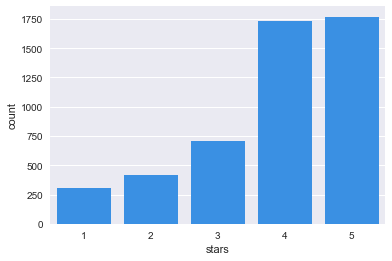

In [17]:
#all stars distribution
# all colors: https://matplotlib.org/_images/named_colors.png
sns.countplot(wine['stars'], color='dodgerblue')

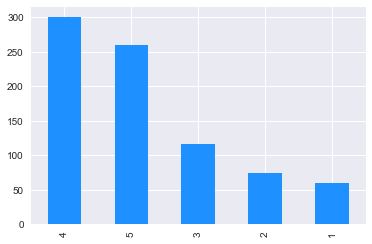

In [18]:
wine[wine.repeat == True].stars.value_counts().plot(kind='bar', color='dodgerblue')

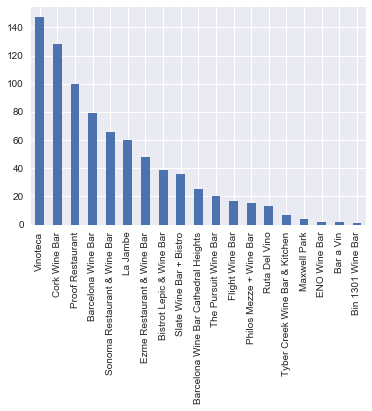

In [19]:
# most repetitively visited restaurants by repeat Yelp customers
wine[wine.repeat == True].rest_name.value_counts().plot(kind='bar')

### A/B test : Do repeat users have statistically signficant lower ratings?

# Out of town vs in town

In [20]:
wine.location.value_counts()

Washington, DC                       1885
Arlington, VA                         297
Alexandria, VA                        159
New York, NY                          116
San Francisco, CA                      98
Silver Spring, MD                      89
Fairfax, VA                            73
Bethesda, MD                           61
Baltimore, MD                          60
Chicago, IL                            58
Los Angeles, CA                        55
Washington D.C., DC                    54
Falls Church, VA                       51
Rockville, MD                          46
Brooklyn, NY                           45
Manhattan, NY                          45
San Diego, CA                          36
Seattle, WA                            31
Philadelphia, PA                       29
Vienna, VA                             26
McLean, VA                             24
Boston, MA                             24
Portland, OR                           22
Austin, TX                        

In [21]:
# define inside / outside beltway
DMV = (wine.location == "Washington, DC") | (wine.location == "Arlington, VA") | (wine.location == "Alexandria, VA") | (wine.location == "Silver Spring, MD") | (wine.location == "Washington D.C., DC") | (wine.location == "Fairfax, VA") | (wine.location == "Falls Church, VA") | (wine.location == "Bethesda, MD")


In [22]:
wine[DMV].shape

(2669, 7)

In [23]:
# what percent is in the DMV?
float(wine[DMV].shape[0]) / wine.shape[0]*100

54.09404134576409

In [24]:
wine['dmv'] = DMV

In [25]:
wine[wine.dmv == True].stars.mean()

3.8220307231172725

In [26]:
wine[wine.dmv == False].stars.mean()

3.9055187637969095

In [27]:
# percent of visits by those in the dmv
wine[wine.dmv == True].rest_name.value_counts()/wine.shape[0]

Barcelona Wine Bar                      0.117754
Proof Restaurant                        0.078435
Vinoteca                                0.078233
Cork Wine Bar                           0.049453
Sonoma Restaurant & Wine Bar            0.039522
Ezme Restaurant & Wine Bar              0.024524
Flight Wine Bar                         0.020876
Barcelona Wine Bar Cathedral Heights    0.020065
Bistrot Lepic & Wine Bar                0.020065
La Jambe                                0.019660
Slate Wine Bar + Bistro                 0.017430
The Pursuit Wine Bar                    0.015403
Ruta Del Vino                           0.010134
Philos Mezze + Wine Bar                 0.006891
Tyber Creek Wine Bar & Kitchen          0.006486
ENO Wine Bar                            0.005675
Bin 1301 Wine Bar                       0.005270
Bar a Vin                               0.002635
Maxwell Park                            0.002432
Name: rest_name, dtype: float64

In [28]:
# percent of visits by those not in the DMV
wine[wine.dmv == False].rest_name.value_counts()/wine.shape[0]

Barcelona Wine Bar                      0.101135
Proof Restaurant                        0.091812
Vinoteca                                0.055533
Sonoma Restaurant & Wine Bar            0.037495
Ezme Restaurant & Wine Bar              0.036279
Cork Wine Bar                           0.035671
Flight Wine Bar                         0.017633
Bistrot Lepic & Wine Bar                0.016417
Slate Wine Bar + Bistro                 0.013174
Barcelona Wine Bar Cathedral Heights    0.012363
The Pursuit Wine Bar                    0.008918
Bin 1301 Wine Bar                       0.006891
La Jambe                                0.006486
ENO Wine Bar                            0.006283
Philos Mezze + Wine Bar                 0.005270
Ruta Del Vino                           0.003243
Tyber Creek Wine Bar & Kitchen          0.001621
Maxwell Park                            0.001419
Bar a Vin                               0.001419
Name: rest_name, dtype: float64

In [29]:
# bump by out of towners?
wine[wine.dmv == False].rest_name.value_counts()/wine.shape[0] - wine[wine.dmv == True].rest_name.value_counts()/wine.shape[0]

Bar a Vin                              -0.001216
Barcelona Wine Bar                     -0.016619
Barcelona Wine Bar Cathedral Heights   -0.007702
Bin 1301 Wine Bar                       0.001621
Bistrot Lepic & Wine Bar               -0.003648
Cork Wine Bar                          -0.013782
ENO Wine Bar                            0.000608
Ezme Restaurant & Wine Bar              0.011755
Flight Wine Bar                        -0.003243
La Jambe                               -0.013174
Maxwell Park                           -0.001013
Philos Mezze + Wine Bar                -0.001621
Proof Restaurant                        0.013377
Ruta Del Vino                          -0.006891
Slate Wine Bar + Bistro                -0.004256
Sonoma Restaurant & Wine Bar           -0.002027
The Pursuit Wine Bar                   -0.006486
Tyber Creek Wine Bar & Kitchen         -0.004864
Vinoteca                               -0.022700
Name: rest_name, dtype: float64

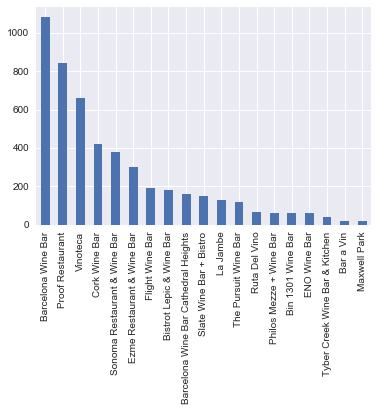

In [30]:
wine.rest_name.value_counts().plot(kind='bar')

### A/B Test: Are out of towners nicer than those in the DMV?

# Restaurant trends over time

In [31]:
wine.dtypes 

rest_name    object
username     object
review       object
stars         int64
date         object
location     object
repeat         bool
dmv            bool
dtype: object

In [32]:
wine.describe()

,stars
count,4934.000000
mean,3.860357
std,1.174324
min,1.000000
25%,3.000000
50%,4.000000
75%,5.000000
max,5.000000


In [33]:
wine.describe(include=['object']) 

,rest_name,username,review,date,location
count,4934,4934,4934,4934,4934
unique,19,4125,4874,2430,735
top,Barcelona Wine Bar,/user_details?userid=A4HjuMo-QgWxsCxXiV5i0A,i had heard that La Jambe had opened right by ...,6/4/2017,"Washington, DC"
freq,1080,54,2,10,1885


In [34]:
wine.describe(include='all')

,rest_name,username,review,stars,date,location,repeat,dmv
count,4934,4934,4934,4934.000000,4934,4934,4934,4934
unique,19,4125,4874,NaN,2430,735,2,2
top,Barcelona Wine Bar,/user_details?userid=A4HjuMo-QgWxsCxXiV5i0A,i had heard that La Jambe had opened right by ...,NaN,6/4/2017,"Washington, DC",False,True
freq,1080,54,2,NaN,10,1885,4125,2669
mean,NaN,NaN,NaN,3.860357,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,1.174324,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,3.000000,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,4.000000,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,5.000000,NaN,NaN,NaN,NaN


In [35]:
wine.describe(include=['object'])

,rest_name,username,review,date,location
count,4934,4934,4934,4934,4934
unique,19,4125,4874,2430,735
top,Barcelona Wine Bar,/user_details?userid=A4HjuMo-QgWxsCxXiV5i0A,i had heard that La Jambe had opened right by ...,6/4/2017,"Washington, DC"
freq,1080,54,2,10,1885


In [36]:
wine[wine.username == '/user_details?userid=A4HjuMo-QgWxsCxXiV5i0A']

,rest_name,username,review,stars,date,location,repeat,dmv
458,Barcelona Wine Bar,/user_details?userid=A4HjuMo-QgWxsCxXiV5i0A,"Best service, best food, best place in DC, sim...",5,9/21/2017,"Germantown, MD",False,False
478,Barcelona Wine Bar,/user_details?userid=A4HjuMo-QgWxsCxXiV5i0A,"This place was, Perfection! We went with anoth...",5,9/10/2017,"Carmel, IN",True,False
498,Barcelona Wine Bar,/user_details?userid=A4HjuMo-QgWxsCxXiV5i0A,"Outstanding. Superlative in service, varied an...",5,7/13/2017,"Omaha, NE",True,False
518,Barcelona Wine Bar,/user_details?userid=A4HjuMo-QgWxsCxXiV5i0A,"Food, service, and atmosphere were all fantast...",5,7/18/2017,"Manhattan, New York, NY",True,False
538,Barcelona Wine Bar,/user_details?userid=A4HjuMo-QgWxsCxXiV5i0A,Came to visit a friend up who lives in DC and ...,5,11/22/2016,"Miami, FL",True,False
558,Barcelona Wine Bar,/user_details?userid=A4HjuMo-QgWxsCxXiV5i0A,What a mess! We waited in a cramped hallway f...,1,3/10/2017,"Reston, VA",True,False
578,Barcelona Wine Bar,/user_details?userid=A4HjuMo-QgWxsCxXiV5i0A,"I love wine bars and tapas, so coming here for...",5,3/12/2017,"Potomac Falls, VA",True,False
598,Barcelona Wine Bar,/user_details?userid=A4HjuMo-QgWxsCxXiV5i0A,We did not have the best experience here and I...,2,6/12/2017,"Midtown, Memphis, TN",True,False
618,Barcelona Wine Bar,/user_details?userid=A4HjuMo-QgWxsCxXiV5i0A,This place had been on my list for a while and...,5,10/17/2016,"Evanston, IL",True,False
638,Barcelona Wine Bar,/user_details?userid=A4HjuMo-QgWxsCxXiV5i0A,Yum tapas in a nice setting. This spot is alon...,4,1/20/2016,"Las Vegas, NV",True,False


In [37]:
wine2 = wine
df = pd.DataFrame(wine2)

In [38]:
df.head()

,rest_name,username,review,stars,date,location,repeat,dmv
0,La Jambe,/user_details?userid=GBjdziANdkk29jjwOBj5ow,This review is massively overdue (I don't writ...,5,8/25/2017,"Washington, DC",False,True
1,La Jambe,/user_details?userid=X3Ki2Z6JTn9gbuz23NO3kg,My friends and I were looking for a good happy...,4,9/25/2017,"Washington, DC",False,True
2,La Jambe,/user_details?userid=dOYJX2FBw5FXDBwXZZoq7A,Elegant and intimate - La Jambe has an unexpec...,4,8/11/2017,"Washington, DC",False,True
3,La Jambe,/user_details?userid=ZaJ6zPDAc7YaDTE2QEBGPA,This place is really special. If your in the a...,5,7/23/2017,"Red Bank, NJ",False,False
4,La Jambe,/user_details?userid=mz8Q8yEOkgjaISIqzUSHLg,Hooray for happy hour! $5 for delicious wines?...,4,7/10/2017,"Washington, DC",False,True


In [39]:
#stars breakdown per category
star1 = df.stars == 1 
star2 = df.stars == 2
star3 = df.stars == 3 
star4 = df.stars == 4 
star5 = df.stars == 5 

In [40]:
star1

0       False
1       False
2       False
3       False
4       False
5       False
6       False
7       False
8       False
9       False
10      False
11      False
12      False
13      False
14      False
15      False
16      False
17      False
18      False
19      False
20      False
21      False
22      False
23      False
24      False
25      False
26      False
27      False
28      False
29      False
        ...  
4904    False
4905    False
4906    False
4907    False
4908    False
4909    False
4910    False
4911    False
4912    False
4913     True
4914    False
4915    False
4916    False
4917    False
4918    False
4919    False
4920    False
4921    False
4922    False
4923    False
4924    False
4925    False
4926    False
4927    False
4928    False
4929    False
4930    False
4931    False
4932    False
4933    False
Name: stars, dtype: bool

In [41]:
star5.head()

0     True
1    False
2    False
3     True
4    False
Name: stars, dtype: bool

In [42]:
type(star5)

pandas.core.series.Series

In [43]:
#viewing only 5 star reviews
df[star5]

,rest_name,username,review,stars,date,location,repeat,dmv
0,La Jambe,/user_details?userid=GBjdziANdkk29jjwOBj5ow,This review is massively overdue (I don't writ...,5,8/25/2017,"Washington, DC",False,True
3,La Jambe,/user_details?userid=ZaJ6zPDAc7YaDTE2QEBGPA,This place is really special. If your in the a...,5,7/23/2017,"Red Bank, NJ",False,False
6,La Jambe,/user_details?userid=W7R6U1ibcHxXBYedVWYQqw,This little gem is a fantastic place for happy...,5,6/23/2017,"Berkeley, CA",False,False
7,La Jambe,/user_details?userid=oe0t5jdk-WHCYqnkRB_reg,Best wine bar happy hour in the Shaw area! A f...,5,12/30/2016,"Washington, DC",False,True
14,La Jambe,/user_details?userid=LtZJ_YZN9eRrFe0N4m8SsA,FYI they are closed on Mondays (found that out...,5,7/19/2017,"Charlotte, NC",False,False
15,La Jambe,/user_details?userid=fyxvvMyF4mIIdigAnuhvaQ,"Cute, clam, affordable wine happy hour. The pl...",5,7/13/2017,"Washington, DC",False,True
16,La Jambe,/user_details?userid=KiyPUvmz2HDmZvP8yiiuxw,Another win in the series of 7th St Shaw bars....,5,5/8/2017,"Washington, DC",False,True
17,La Jambe,/user_details?userid=wklmU8CM7czQQBuhOC4k9A,Love this place. Top shelf staff who were aut...,5,5/27/2017,"Chicago, IL",False,False
20,La Jambe,/user_details?userid=uEWsWCNKTTaQ0dTT-mft8Q,"Best wine bar in DC, amazing wines, delicious ...",5,9/10/2017,"Washington, DC",False,True
23,La Jambe,/user_details?userid=E-UoJyyrhaGGk_aU0r1ulQ,Loved this place! Perfect for a Francophile li...,5,7/12/2017,"Washington, DC",False,True


In [44]:
#converting only 5 star reviews to a separate csv
dataframe_star5 = df[star5]
star5_df = pd.DataFrame(dataframe_star5)
star5_df.to_csv('star5nlp.csv')

In [45]:
#testing for 5 stars
star5_df.describe()

,stars
count,1769.0
mean,5.0
std,0.0
min,5.0
25%,5.0
50%,5.0
75%,5.0
max,5.0


In [46]:
#alright, it worked, now let's do it for everyone
##4 stars
dataframe_star4 = df[star4]
star4_df = pd.DataFrame(dataframe_star4)
star4_df.to_csv('star4nlp.csv')
##3 stars
dataframe_star3 = df[star3]
star3_df = pd.DataFrame(dataframe_star3)
star3_df.to_csv('star3nlp.csv')
#2 stars
dataframe_star2 = df[star2]
star2_df = pd.DataFrame(dataframe_star2)
star2_df.to_csv('star2nlp.csv')
#1 stars
dataframe_star1 = df[star1]
star1_df = pd.DataFrame(dataframe_star1)
star1_df.to_csv('star1nlp.csv')

Got the data frames, let's look at the word frequencies...what are people talking about

### 5 Stars

In [47]:
star5nlp = pd.read_csv('star5nlp.csv')

In [48]:
#shorten format to review slip
text_star5 = star5nlp.review

In [49]:
text_star5

0       This review is massively overdue (I don't writ...
1       This place is really special. If your in the a...
2       This little gem is a fantastic place for happy...
3       Best wine bar happy hour in the Shaw area! A f...
4       FYI they are closed on Mondays (found that out...
5       Cute, clam, affordable wine happy hour. The pl...
6       Another win in the series of 7th St Shaw bars....
7       Love this place.  Top shelf staff who were aut...
8       Best wine bar in DC, amazing wines, delicious ...
9       Loved this place! Perfect for a Francophile li...
10      Hot damn. What a phenomenal place. Interesting...
11      Don't let the "wine bar" category fool you--th...
12      CUUUUUTEST little wine bar!  It just oooozes P...
13      My wife and I went to La Jambe on a Friday nig...
14      I went with my boyfriend and a friend on a Sat...
15      Just ma type of place! Authentic French wine b...
16      I live in the Shaw neighborhood and passed thi...
17      Excell

In [50]:
'''
create a document term matrix with:
-ngram range 1,2
-minimum document appearance for any term = 2
-removal of all English stop words
'''
vect = CountVectorizer(ngram_range=(1, 2), stop_words='english', min_df=2)
dtm = vect.fit_transform(text_star5)

In [51]:
# do the above, but make a dataframe with feature names = words
tf5 = pd.DataFrame(vect.fit_transform(text_star5).toarray(), columns=vect.get_feature_names())

In [52]:
# see most common terms
tf5.sum().sort_values(ascending=False)

wine              1571
great             1483
food              1335
place              977
service            873
good               855
bar                645
delicious          611
really             566
cheese             563
amazing            560
just               554
time               535
restaurant         488
menu               481
like               477
night              477
definitely         470
ve                 413
staff              409
best               405
love               404
tapas              403
nice               401
ordered            399
dc                 389
dinner             379
table              367
excellent          364
barcelona          346
                  ... 
menu quality         2
menu pretty          2
menu prepared        2
menu patatas         2
menu simple          2
menu overall         2
menu online          2
menu offers          2
menu notch           2
menu mentioned       2
menu meat            2
menu service         2
menu smalle

In [53]:
#chart it
# plot 12 most used terms
#tf5.sort_values(['sum'], ascending=False).drop('sum', axis=1).head(12).plot(kind='bar')

### 4 stars

In [54]:
star4nlp = pd.read_csv('star4nlp.csv')

In [55]:
#shorten format to review slip
text_star4 = star4nlp.review

In [56]:
'''
create a document term matrix with:
-ngram range 1,2
-minimum document appearance for any term = 2
-removal of all English stop words
'''
vect = CountVectorizer(ngram_range=(1, 2), stop_words='english', min_df=2)
dtm = vect.fit_transform(text_star4)

In [57]:
# do the above, but make a dataframe with feature names = words
tf4 = pd.DataFrame(vect.fit_transform(text_star4).toarray(), columns=vect.get_feature_names())

In [58]:
# see most common terms
tf4.sum().sort_values(ascending=False)

wine                   1994
good                   1500
great                  1426
food                   1325
place                   984
really                  815
bar                     807
cheese                  735
service                 685
like                    663
nice                    663
just                    634
menu                    612
delicious               602
time                    556
ordered                 520
night                   514
happy                   504
hour                    465
definitely              448
restaurant              447
little                  442
small                   433
dinner                  429
came                    421
wines                   409
got                     407
happy hour              389
ve                      381
table                   380
                       ... 
meat board                2
meat balls                2
means good                2
mean think                2
meal wonderful      

### 3 Stars

In [59]:
star3nlp = pd.read_csv('star3nlp.csv')

In [60]:
#shorten format to review slip
text_star3 = star3nlp.review

In [61]:
'''
create a document term matrix with:
-ngram range 1,2
-minimum document appearance for any term = 2
-removal of all English stop words
'''
vect = CountVectorizer(ngram_range=(1, 2), stop_words='english', min_df=2)
dtm = vect.fit_transform(text_star3)

In [62]:
# do the above, but make a dataframe with feature names = words
tf3 = pd.DataFrame(vect.fit_transform(text_star3).toarray(), columns=vect.get_feature_names())

In [63]:
# see most common terms
tf3.sum().sort_values(ascending=False)

wine              863
good              716
food              716
place             433
just              413
service           386
great             381
bar               376
really            367
like              352
nice              287
cheese            279
menu              267
ordered           264
restaurant        251
time              238
table             228
came              225
small             222
didn              211
pretty            205
little            199
got               195
did               189
night             188
dinner            184
bit               171
glass             170
went              169
hour              163
                 ... 
just perfect        2
just people         2
just order          2
squash little       2
just need           2
just mind           2
just meh            2
just know           2
just knew           2
just kept           2
just isn            2
just hope           2
just going          2
just finishing      2
just ended

### 2 Stars

In [64]:
star2nlp = pd.read_csv('star2nlp.csv')

In [65]:
#shorten format to review slip
text_star2 = star2nlp.review

In [66]:
'''
create a document term matrix with:
-ngram range 1,2
-minimum document appearance for any term = 2
-removal of all English stop words
'''
vect = CountVectorizer(ngram_range=(1, 2), stop_words='english', min_df=2)
dtm = vect.fit_transform(text_star2)

In [67]:
# do the above, but make a dataframe with feature names = words
tf2 = pd.DataFrame(vect.fit_transform(text_star2).toarray(), columns=vect.get_feature_names())

In [68]:
# see most common terms
tf2.sum().sort_values(ascending=False)

wine                    495
food                    491
good                    316
service                 284
place                   261
bar                     242
just                    239
like                    230
table                   199
really                  198
ordered                 184
time                    178
restaurant              167
menu                    166
great                   158
came                    155
order                   153
did                     138
didn                    138
don                     134
server                  127
got                     119
night                   118
experience              117
cheese                  116
went                    113
dinner                  112
nice                    110
small                   110
asked                   109
                       ... 
red peppers               2
reflected                 2
fork mouth                2
regarding                 2
related             

### 1 Stars

In [69]:
star1nlp = pd.read_csv('star1nlp.csv')

In [70]:
#shorten format to review slip
text_star1 = star1nlp.review

In [71]:
'''
create a document term matrix with:
-ngram range 1,2
-minimum document appearance for any term = 2
-removal of all English stop words
'''
vect = CountVectorizer(ngram_range=(1, 2), stop_words='english', min_df=2)
dtm = vect.fit_transform(text_star1)

In [72]:
# do the above, but make a dataframe with feature names = words
tf1 = pd.DataFrame(vect.fit_transform(text_star1).toarray(), columns=vect.get_feature_names())

In [73]:
# see most common terms
tf1.sum().sort_values(ascending=False)

wine                    278
food                    249
table                   188
service                 181
bar                     169
just                    166
place                   159
restaurant              157
asked                   142
time                    139
like                    124
minutes                 118
came                    118
ordered                 108
good                    107
experience              104
said                    103
told                    102
order                   102
night                    98
reservation              96
did                      95
menu                     94
manager                  93
went                     90
really                   88
didn                     87
wait                     85
don                      85
got                      83
                       ... 
sight                     2
honor reservations        2
sigh                      2
situation thoughtful      2
heard good          

# Restaurant Review Value over Time

In [74]:
wine.head()

,rest_name,username,review,stars,date,location,repeat,dmv
0,La Jambe,/user_details?userid=GBjdziANdkk29jjwOBj5ow,This review is massively overdue (I don't writ...,5,8/25/2017,"Washington, DC",False,True
1,La Jambe,/user_details?userid=X3Ki2Z6JTn9gbuz23NO3kg,My friends and I were looking for a good happy...,4,9/25/2017,"Washington, DC",False,True
2,La Jambe,/user_details?userid=dOYJX2FBw5FXDBwXZZoq7A,Elegant and intimate - La Jambe has an unexpec...,4,8/11/2017,"Washington, DC",False,True
3,La Jambe,/user_details?userid=ZaJ6zPDAc7YaDTE2QEBGPA,This place is really special. If your in the a...,5,7/23/2017,"Red Bank, NJ",False,False
4,La Jambe,/user_details?userid=mz8Q8yEOkgjaISIqzUSHLg,Hooray for happy hour! $5 for delicious wines?...,4,7/10/2017,"Washington, DC",False,True


In [75]:
wine.dtypes

rest_name    object
username     object
review       object
stars         int64
date         object
location     object
repeat         bool
dmv            bool
dtype: object

In [76]:
ts = wine.set_index('date')

In [77]:
ts.head()

,rest_name,username,review,stars,location,repeat,dmv
date,,,,,,,
8/25/2017,La Jambe,/user_details?userid=GBjdziANdkk29jjwOBj5ow,This review is massively overdue (I don't writ...,5,"Washington, DC",False,True
9/25/2017,La Jambe,/user_details?userid=X3Ki2Z6JTn9gbuz23NO3kg,My friends and I were looking for a good happy...,4,"Washington, DC",False,True
8/11/2017,La Jambe,/user_details?userid=dOYJX2FBw5FXDBwXZZoq7A,Elegant and intimate - La Jambe has an unexpec...,4,"Washington, DC",False,True
7/23/2017,La Jambe,/user_details?userid=ZaJ6zPDAc7YaDTE2QEBGPA,This place is really special. If your in the a...,5,"Red Bank, NJ",False,False
7/10/2017,La Jambe,/user_details?userid=mz8Q8yEOkgjaISIqzUSHLg,Hooray for happy hour! $5 for delicious wines?...,4,"Washington, DC",False,True


In [78]:
ts.index = pd.to_datetime(ts.index)

In [79]:
ts.head()

,rest_name,username,review,stars,location,repeat,dmv
date,,,,,,,
2017-08-25,La Jambe,/user_details?userid=GBjdziANdkk29jjwOBj5ow,This review is massively overdue (I don't writ...,5,"Washington, DC",False,True
2017-09-25,La Jambe,/user_details?userid=X3Ki2Z6JTn9gbuz23NO3kg,My friends and I were looking for a good happy...,4,"Washington, DC",False,True
2017-08-11,La Jambe,/user_details?userid=dOYJX2FBw5FXDBwXZZoq7A,Elegant and intimate - La Jambe has an unexpec...,4,"Washington, DC",False,True
2017-07-23,La Jambe,/user_details?userid=ZaJ6zPDAc7YaDTE2QEBGPA,This place is really special. If your in the a...,5,"Red Bank, NJ",False,False
2017-07-10,La Jambe,/user_details?userid=mz8Q8yEOkgjaISIqzUSHLg,Hooray for happy hour! $5 for delicious wines?...,4,"Washington, DC",False,True


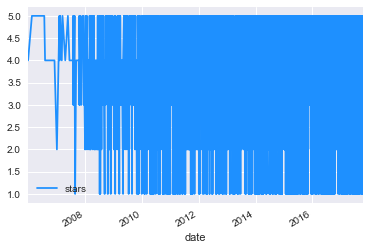

In [80]:
ts.plot(x=ts.index, y = 'stars', color='dodgerblue')

In [81]:
ts['date'] = ts.index

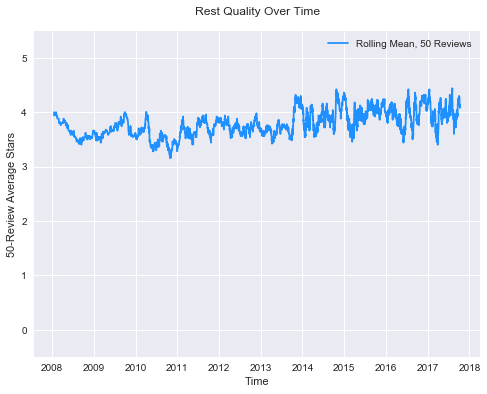

In [82]:
fig = plt.figure(figsize=(8, 6))
plt.plot(ts.sort_values(by='date').stars.rolling(window=50,center=False).mean(), label='Rolling Mean, 50 Reviews', color='dodgerblue')
plt.legend(loc='best')
plt.ylim(-0.5, 5.5)
plt.title('Rest Quality Over Time', y=1.03)
plt.ylabel('50-Review Average Stars')
plt.xlabel('Time')

In [83]:
ts.sort_values(by='date')[ts.sort_values(by='date').rest_name == 'Vinoteca'].stars

date
2007-12-30    3
2008-01-05    2
2008-01-06    4
2008-01-17    2
2008-02-12    2
2008-02-13    4
2008-02-17    3
2008-04-10    5
2008-04-13    4
2008-04-18    4
2008-05-18    4
2008-05-22    2
2008-05-26    2
2008-06-05    4
2008-06-17    2
2008-06-19    4
2008-06-24    4
2008-06-25    3
2008-06-30    3
2008-07-01    3
2008-07-02    3
2008-07-25    3
2008-08-31    4
2008-09-01    3
2008-09-23    4
2008-10-19    4
2008-10-20    5
2008-10-22    1
2008-10-27    4
2008-10-28    5
             ..
2017-02-21    4
2017-02-23    3
2017-03-05    3
2017-03-12    3
2017-04-10    4
2017-04-13    3
2017-04-23    2
2017-04-29    5
2017-05-01    2
2017-05-12    2
2017-05-26    3
2017-05-30    4
2017-06-08    4
2017-06-12    5
2017-06-17    1
2017-06-18    2
2017-06-22    4
2017-06-28    4
2017-07-14    2
2017-07-19    5
2017-07-20    4
2017-08-05    2
2017-08-18    1
2017-08-26    4
2017-09-02    1
2017-09-09    2
2017-09-19    3
2017-09-27    1
2017-10-08    3
2017-10-08    3
Name: stars, dtype:

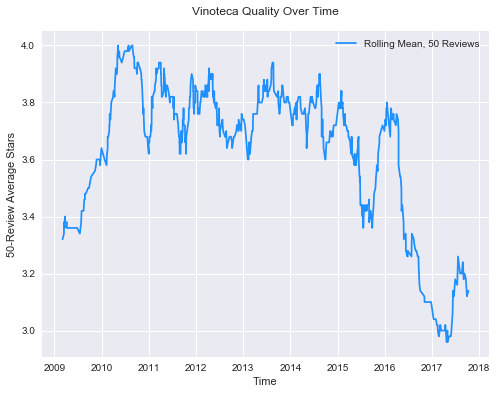

In [84]:
# vinoteca performance over time
fig = plt.figure(figsize=(8, 6))
plt.plot(ts.sort_values(by='date')[ts.sort_values(by='date').rest_name == 'Vinoteca'].stars.rolling(window=50,center=False).mean(), label='Rolling Mean, 50 Reviews', color='dodgerblue')
plt.legend(loc='best')
plt.title('Vinoteca Quality Over Time', y=1.03)
plt.ylabel('50-Review Average Stars')
plt.xlabel('Time')

In [85]:
# vinoteca performance over time
def plot_rest_quality(rest_name, n_reviews):
    fig = plt.figure(figsize=(8, 6))
    plt.plot(ts.sort_values(by='date')[ts.sort_values(by='date').rest_name == rest_name].stars.rolling(window=n_reviews,center=False).mean(), label='Rolling Mean %d Reviews' %n_reviews, color='dodgerblue')
    plt.ylim(-0.5,5.5)
    plt.legend(loc='best')
    plt.title('%s Quality Over Time'%rest_name, y=1.03)
    plt.ylabel('%d -Review Average Stars'%n_reviews)
    plt.xlabel('Time')

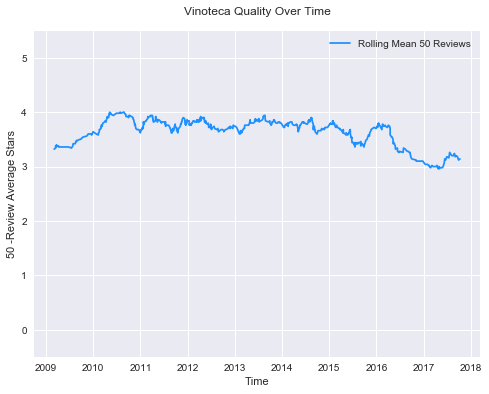

In [86]:
plot_rest_quality('Vinoteca', 50)

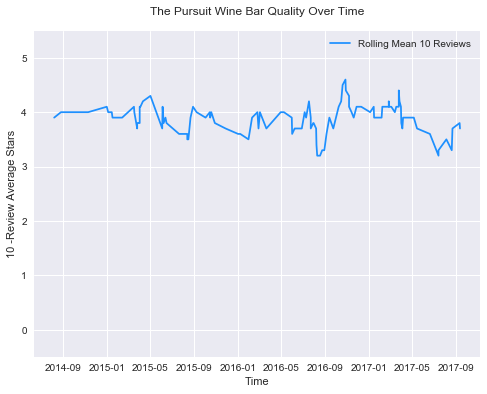

In [87]:
plot_rest_quality('The Pursuit Wine Bar', 10)

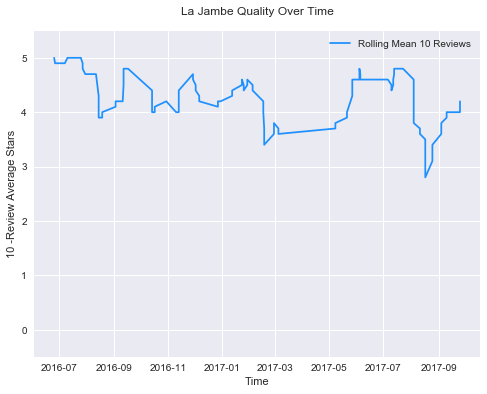

In [88]:
plot_rest_quality('La Jambe', 10)

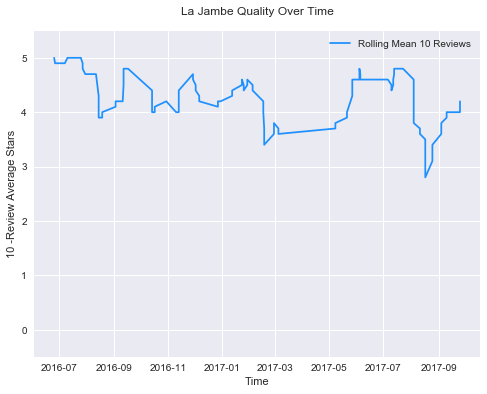

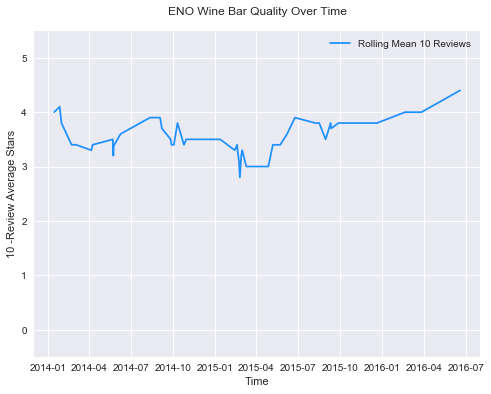

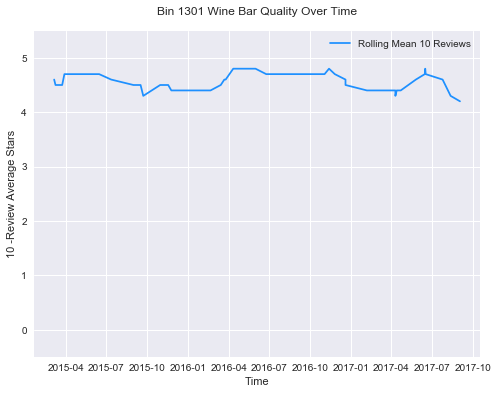

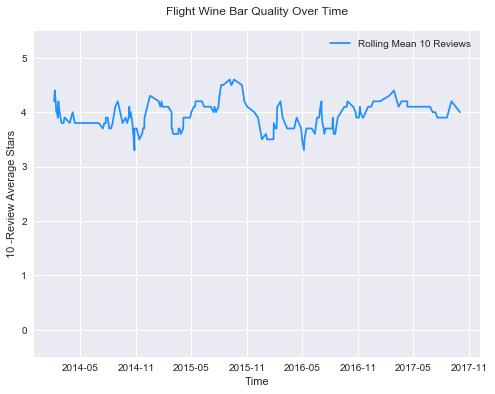

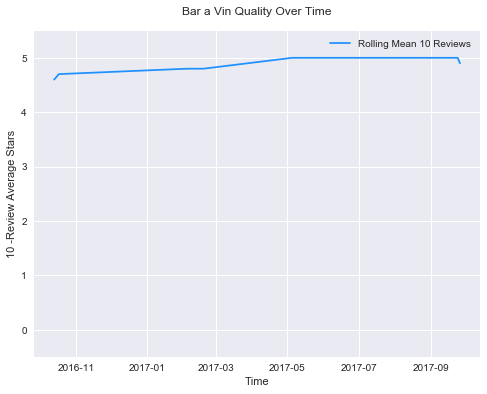

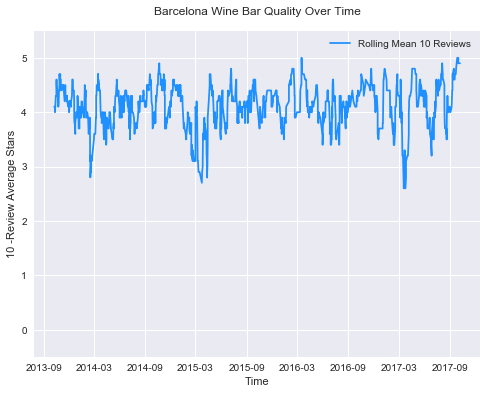

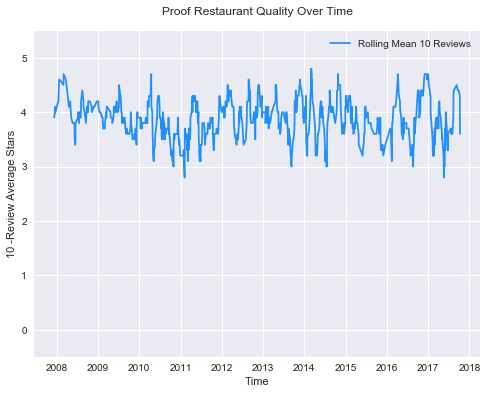

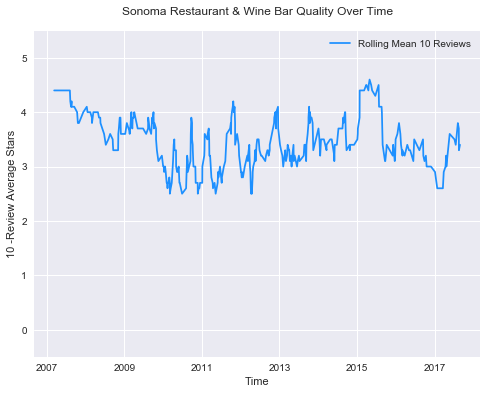

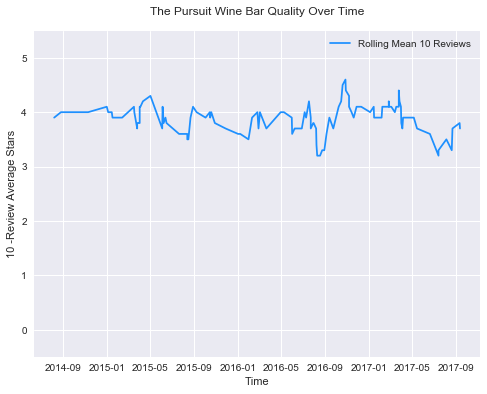

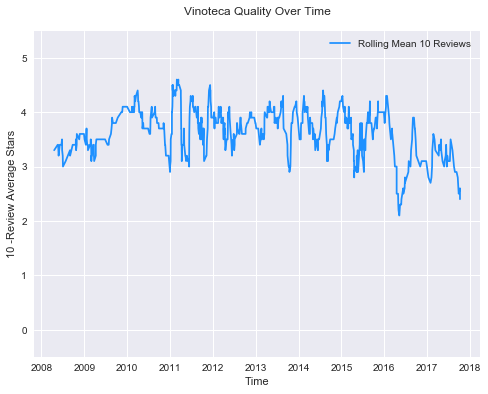

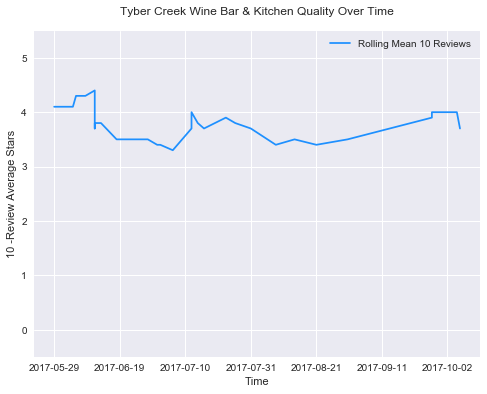

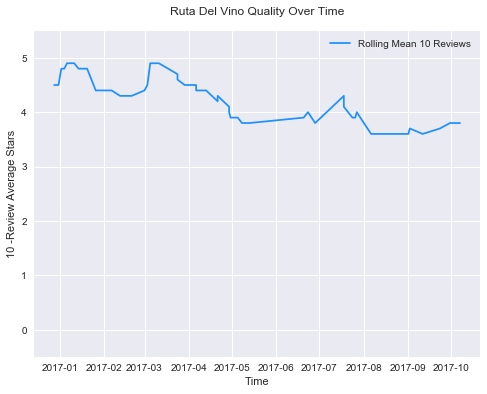

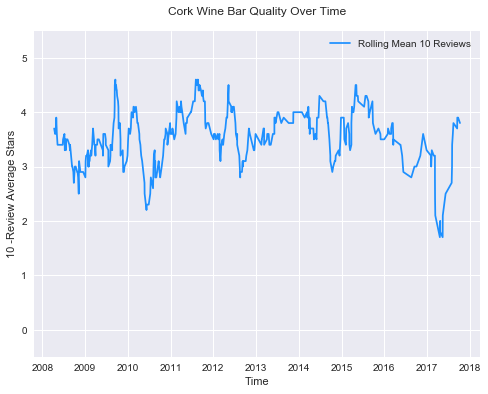

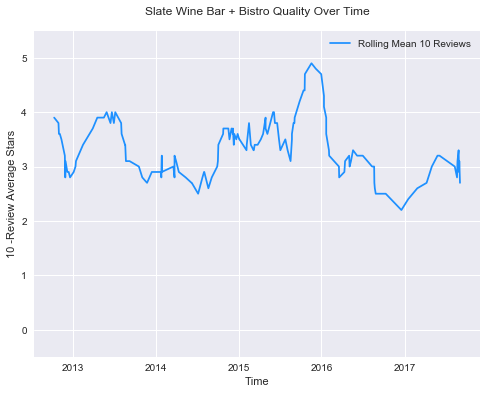

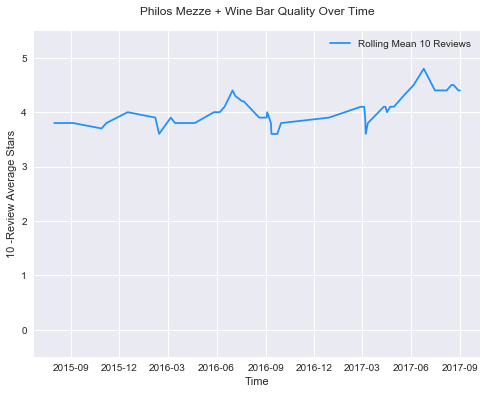

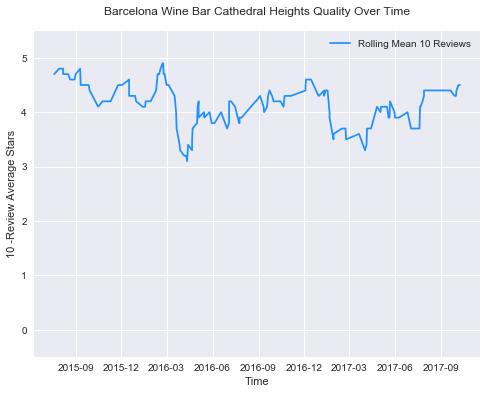

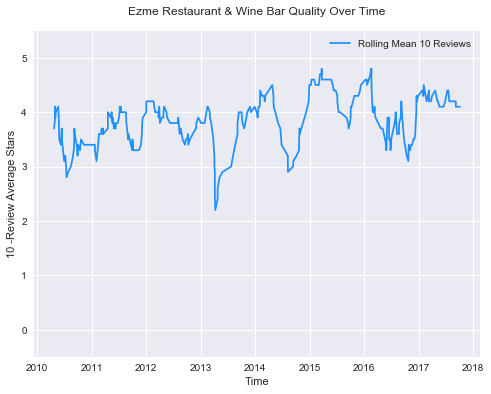

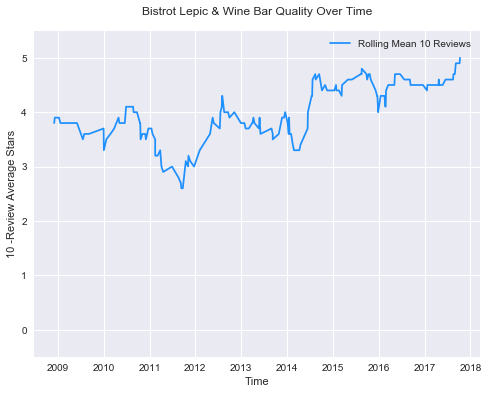

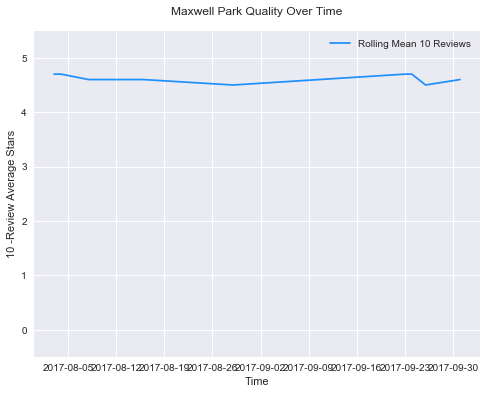

In [89]:
for restaurant in wine.rest_name.unique():
    plot_rest_quality(restaurant, 10)

We want to know:
- Volume of reviews during each of these times
- When restaurants have dips or upticks, why?

In [90]:
# predict what causes good / bad reviews!
# predict 4 star and above reviews 
# predict "good" and "bad" reviews for a given restaurant (predict if a given review is above/below the average for that given restaurant)


###Text Processing

In [91]:
text = wine.review

In [92]:
print(text[0:5])

0    This review is massively overdue (I don't writ...
1    My friends and I were looking for a good happy...
2    Elegant and intimate - La Jambe has an unexpec...
3    This place is really special. If your in the a...
4    Hooray for happy hour! $5 for delicious wines?...
Name: review, dtype: object


In [93]:
# investigate single entry
text[0]

"This review is massively overdue (I don't write a lot of reviews). My husband and I are semi-regulars at this place. Anastasia and Dave are friendly people with great taste, and they have created wonderful, unpretentious wine bar. The wine list is delicious - we have our favorites like everyone but have never had a bad wine from their list - and the staff give great advice if you're not sure. Anastasia even gave us recommendations about which wineries to hit up in her native land on our summer vacation.\r\n\r\nThe food is yummy too, if you're okay with the dishes being a bit on the small side for the price.\r\n\r\nOverall, this place has us coming back on the regular. The only downside is they've been so successful that it's rarer to see Anastasia and Dave hanging around these days, but that just means they've been doing well. \r\n\r\nA must-try if you live in the U Street/Shaw/Mt. Vernon area.\r\n"

In [94]:
# eliminate encoding like 
# StackOverflow decoding function iwth light edits http://stackoverflow.com/questions/27996448/python-encoding-decoding-problems
def unicodetoascii(text):

    uni2ascii = {
            ord('\xe2\x80\x99'.decode('utf-8')): ord("'"),
            ord('\xe2\x80\x9c'.decode('utf-8')): ord('"'),
            ord('\xe2\x80\x9d'.decode('utf-8')): ord('"'),
            ord('\xe2\x80\x9e'.decode('utf-8')): ord('"'),
            ord('\xe2\x80\x9f'.decode('utf-8')): ord('"'),
            ord('\xc3\xa9'.decode('utf-8')): ord('e'),
            ord('\xe2\x80\x9c'.decode('utf-8')): ord('"'),
            ord('\xe2\x80\x93'.decode('utf-8')): ord('-'),
            ord('\xe2\x80\x92'.decode('utf-8')): ord('-'),
            ord('\xe2\x80\x94'.decode('utf-8')): ord('-'),
            ord('\xe2\x80\x94'.decode('utf-8')): ord('-'),
            ord('\xe2\x80\x98'.decode('utf-8')): ord("'"),
            ord('\xe2\x80\x9b'.decode('utf-8')): ord("'"),

            ord('\xe2\x80\x90'.decode('utf-8')): ord('-'),
            ord('\xe2\x80\x91'.decode('utf-8')): ord('-'),

            ord('\xe2\x80\xb2'.decode('utf-8')): ord("'"),
            ord('\xe2\x80\xb3'.decode('utf-8')): ord("'"),
            ord('\xe2\x80\xb4'.decode('utf-8')): ord("'"),
            ord('\xe2\x80\xb5'.decode('utf-8')): ord("'"),
            ord('\xe2\x80\xb6'.decode('utf-8')): ord("'"),
            ord('\xe2\x80\xb7'.decode('utf-8')): ord("'"),

            ord('\xe2\x81\xba'.decode('utf-8')): ord("+"),
            ord('\xe2\x81\xbb'.decode('utf-8')): ord("-"),
            ord('\xe2\x81\xbc'.decode('utf-8')): ord("="),
            ord('\xe2\x81\xbd'.decode('utf-8')): ord("("),
            ord('\xe2\x81\xbe'.decode('utf-8')): ord(")"),

                            }
    try:
        return text.decode('utf-8').translate(uni2ascii).encode('ascii')
    except:
        return text

In [95]:
# check it
print(unicodetoascii(text[0]))

This review is massively overdue (I don't write a lot of reviews). My husband and I are semi-regulars at this place. Anastasia and Dave are friendly people with great taste, and they have created wonderful, unpretentious wine bar. The wine list is delicious - we have our favorites like everyone but have never had a bad wine from their list - and the staff give great advice if you're not sure. Anastasia even gave us recommendations about which wineries to hit up in her native land on our summer vacation.

The food is yummy too, if you're okay with the dishes being a bit on the small side for the price.

Overall, this place has us coming back on the regular. The only downside is they've been so successful that it's rarer to see Anastasia and Dave hanging around these days, but that just means they've been doing well. 

A must-try if you live in the U Street/Shaw/Mt. Vernon area.



In [96]:
# apply the above to the whole dataframe
wine['review'] = wine.review.apply(unicodetoascii)

In [97]:
# export cleaner file to csv as clean file
wine.to_csv('wine_cleaned.csv')

In [98]:
wine = pd.read_csv('wine_cleaned.csv')
text = wine.review

In [99]:
'''
create a document term matrix with:
-ngram range 1,2
-minimum document appearance for any term = 2
-removal of all English stop words
'''
vect = CountVectorizer(ngram_range=(1, 2), stop_words='english', min_df=2)
dtm = vect.fit_transform(text)

In [100]:
# do the above, but make a dataframe with feature names = words
tf = pd.DataFrame(vect.fit_transform(text).toarray(), columns=vect.get_feature_names())

In [101]:
# see most common terms
tf.sum().sort_values(ascending=False)

wine                  5201
food                  4116
great                 3503
good                  3494
place                 2814
service               2409
bar                   2239
really                2034
just                  2006
like                  1846
cheese                1740
time                  1646
menu                  1620
nice                  1518
restaurant            1510
ordered               1475
delicious             1396
night                 1395
table                 1362
came                  1242
dinner                1174
got                   1120
definitely            1089
ve                    1087
happy                 1081
hour                  1074
small                 1072
went                  1000
little                 981
experience             973
                      ... 
refusing                 2
frustrated fact          2
refreshing summer        2
fryer                    2
refreshing light         2
refreshing hot           2
f

In [102]:
# create first term df
wine_2016_post = wine[wine.date < '12/31/2015']

In [103]:
wine_2016_post.shape

(1404, 9)

In [104]:
# vectorize terms from first term
tf1 = pd.DataFrame(vect.fit_transform(wine_2016_post.review).toarray(), columns=vect.get_feature_names())

In [105]:
# check value counts
tf1.sum().sort_values(ascending=False)

wine                   1566
food                   1178
good                   1046
great                  1032
place                   798
service                 688
bar                     683
really                  617
just                    565
like                    535
time                    510
cheese                  493
nice                    462
restaurant              449
menu                    441
night                   435
dinner                  412
ordered                 410
delicious               396
table                   385
came                    379
got                     333
definitely              331
tapas                   314
ve                      310
don                     303
hour                    302
went                    298
experience              290
happy                   290
                       ... 
reason don                2
reason brunch             2
friend looking            2
friend happy              2
recommend coming    

In [106]:
# create second term df
wine_2016_pre = wine[wine.date > '12/31/2015']

In [107]:
wine_2016_pre.shape

(3528, 9)

In [108]:
# vectorize terms from first term
tf2 = pd.DataFrame(vect.fit_transform(wine_2016_pre.review).toarray(), columns=vect.get_feature_names())

In [109]:
# check totals
tf2.sum().sort_values(ascending=False)

wine                      3630
food                      2936
great                     2470
good                      2445
place                     2015
service                   1719
bar                       1555
just                      1439
really                    1417
like                      1311
cheese                    1247
menu                      1179
time                      1135
ordered                   1064
restaurant                1061
nice                      1054
delicious                  998
table                      977
night                      960
came                       862
happy                      791
got                        787
small                      783
ve                         777
hour                       772
dinner                     759
definitely                 757
little                     712
went                       701
glass                      693
                          ... 
gem street                   2
reservat

In [110]:
# word counts of first and second term
word_counts = pd.merge(pd.DataFrame(data=tf1.sum().sort_values(ascending=False)),pd.DataFrame(data=tf2.sum().sort_values(ascending=False)),how='outer',left_index=True,right_index=True)
print(word_counts)

                    0_x    0_y
00                 18.0   45.0
00 bottomless       NaN    2.0
00 good             NaN    2.0
00 pm               8.0    6.0
00 reservation      2.0    NaN
000                 2.0    3.0
00pm                4.0    7.0
00pm reservation    2.0    NaN
01                  2.0    NaN
08                  4.0    2.0
09                  3.0    2.0
10                 88.0  272.0
10 00               NaN    3.0
10 10               2.0    7.0
10 12               2.0    5.0
10 15               NaN    8.0
10 20               NaN    2.0
10 30               3.0   11.0
10 30pm             NaN    2.0
10 50               NaN    2.0
10 bad              NaN    2.0
10 bottomless       2.0   17.0
10 bucks            2.0    3.0
10 day              NaN    2.0
10 dishes           NaN    2.0
10 dollars          NaN    2.0
10 don              2.0    NaN
10 drink            NaN    2.0
10 end              NaN    2.0
10 food             NaN    2.0
...                 ...    ...
yummy se

In [111]:
# rename columns
word_counts.columns = ['2016_onward', '2015_prior_to'] 

In [112]:
# view the df
word_counts.head()

,2016_onward,2015_prior_to
00,18.0,45.0
00 bottomless,NaN,2.0
00 good,NaN,2.0
00 pm,8.0,6.0
00 reservation,2.0,NaN


In [113]:
# find sums
word_counts['sum'] = word_counts['2016_onward'] + word_counts['2015_prior_to'] 

In [114]:
# sort by most used values
word_counts.sort_values(['sum'], ascending=False)

,2016_onward,2015_prior_to,sum
wine,1566.0,3630.0,5196.0
food,1178.0,2936.0,4114.0
great,1032.0,2470.0,3502.0
good,1046.0,2445.0,3491.0
place,798.0,2015.0,2813.0
service,688.0,1719.0,2407.0
bar,683.0,1555.0,2238.0
really,617.0,1417.0,2034.0
just,565.0,1439.0,2004.0
like,535.0,1311.0,1846.0


In [115]:
# curiousity
word_counts.transpose()

,00,00 bottomless,00 good,00 pm,00 reservation,000,00pm,00pm reservation,01,08,...,zone,zoo,zucchini,zucchini cakes,zucchini fritter,zucchini fritters,zucchini pancake,zucchini pancakes,zuchini,zutant
2016_onward,18.0,NaN,NaN,8.0,2.0,2.0,4.0,2.0,2.0,4.0,...,3.0,NaN,15.0,NaN,2.0,4.0,NaN,6.0,2.0,NaN
2015_prior_to,45.0,2.0,2.0,6.0,NaN,3.0,7.0,NaN,NaN,2.0,...,4.0,2.0,52.0,5.0,NaN,11.0,2.0,19.0,NaN,3.0
sum,63.0,NaN,NaN,14.0,NaN,5.0,11.0,NaN,NaN,6.0,...,7.0,NaN,67.0,NaN,NaN,15.0,NaN,25.0,NaN,NaN


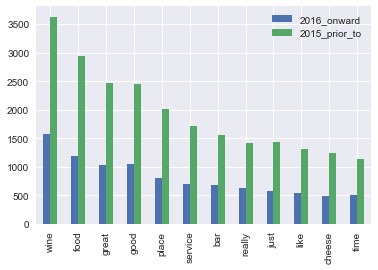

In [116]:
# plot 12 most used terms
word_counts.sort_values(['sum'], ascending=False).drop('sum', axis=1).head(12).plot(kind='bar')

Sentiment Analysis

In [117]:
# grab a story with Textblob
story = TextBlob(wine.review[0])

In [118]:
# polarity ranges from -1 (most negative) to 1 (most positive)
story.sentiment.polarity

0.2600852272727273

In [119]:
# define a function that accepts text and returns the polarity
def detect_sentiment(text):
    return TextBlob(text.decode('utf-8')).sentiment.polarity

In [120]:
wine['sentiment'] = wine.review.apply(detect_sentiment)

In [121]:
wine.sentiment.describe()

count    4934.000000
mean        0.283558
std         0.195683
min        -1.000000
25%         0.173011
50%         0.279010
75%         0.394736
max         1.000000
Name: sentiment, dtype: float64

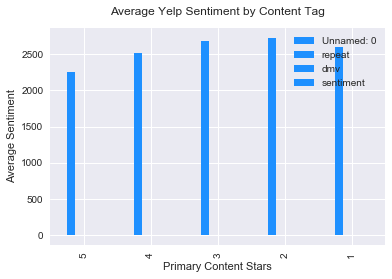

In [122]:
# plot sentiment
wine.groupby('stars').mean().sort_values('sentiment', ascending=False).plot(kind='bar', color='dodgerblue')
plt.xlabel('Primary Content Stars')
plt.ylabel('Average Sentiment')
plt.title('Average Yelp Sentiment by Content Tag', y=1.03)
plt.show()

# Sentiment Analysis

In [125]:
wine.head()

,Unnamed: 0,rest_name,username,review,stars,date,location,repeat,dmv,sentiment
0,0,La Jambe,/user_details?userid=GBjdziANdkk29jjwOBj5ow,This review is massively overdue (I don't writ...,5,8/25/2017,"Washington, DC",False,True,0.260085
1,1,La Jambe,/user_details?userid=X3Ki2Z6JTn9gbuz23NO3kg,My friends and I were looking for a good happy...,4,9/25/2017,"Washington, DC",False,True,0.411384
2,2,La Jambe,/user_details?userid=dOYJX2FBw5FXDBwXZZoq7A,Elegant and intimate - La Jambe has an unexpec...,4,8/11/2017,"Washington, DC",False,True,0.338235
3,3,La Jambe,/user_details?userid=ZaJ6zPDAc7YaDTE2QEBGPA,This place is really special. If your in the a...,5,7/23/2017,"Red Bank, NJ",False,False,0.401429
4,4,La Jambe,/user_details?userid=mz8Q8yEOkgjaISIqzUSHLg,Hooray for happy hour! $5 for delicious wines?...,4,7/10/2017,"Washington, DC",False,True,0.316964


In [126]:
wine['review'] = wine.review.apply(unicodetoascii)

In [127]:
wine.review

0       This review is massively overdue (I don't writ...
1       My friends and I were looking for a good happy...
2       Elegant and intimate - La Jambe has an unexpec...
3       This place is really special. If your in the a...
4       Hooray for happy hour! $5 for delicious wines?...
5       $5 happy hour wines at the corner gem La Jambe...
6       This little gem is a fantastic place for happy...
7       Best wine bar happy hour in the Shaw area! A f...
8       Asked the owner's husband for a recommendation...
9       Great crepes at brunch! The mimosas were espec...
10      This is a pretty decent wine bar. It's laid ba...
11      Great food and service, but some of the prices...
12      I had the chance to check out La Jambe during ...
13      I took a friend here for birthday drinks and w...
14      FYI they are closed on Mondays (found that out...
15      Cute, clam, affordable wine happy hour. The pl...
16      Another win in the series of 7th St Shaw bars....
17      Love t

In [128]:
analyzer = SentimentIntensityAnalyzer()

In [129]:
vs = analyzer.polarity_scores(wine.review[0])

In [130]:
vs['compound']

0.9854

In [131]:
def get_sentiment(text):
    vs = analyzer.polarity_scores(text)
    return vs['compound']

In [132]:
get_sentiment(wine.review[0])

0.9854

In [133]:
# method one
sent_list = []
for x in wine.review:
    sent_list.append(get_sentiment(x))

wine['sentiment'] = sent_list

In [134]:
# method two: apply functions
wine['sentiment'] = wine.review.apply(get_sentiment)

In [135]:
wine['sentiment'].describe()

count    4934.000000
mean        0.796606
std         0.421046
min        -0.989600
25%         0.864275
50%         0.960600
75%         0.986000
max         0.999800
Name: sentiment, dtype: float64

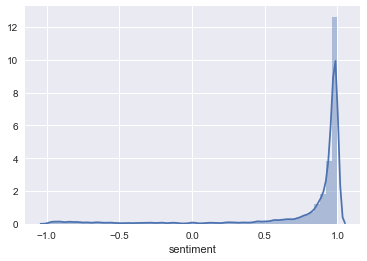

In [136]:
sns.distplot(wine.sentiment)

In [137]:
wine[wine.sentiment < 0].shape

(343, 10)

In [138]:
for x in wine.sort_values(by='sentiment').head(10).review:
    print x

bad service + indignant management = disastrous dinner

The food at Proof is delicious both times that I've been. The service was great the first time, but over Labor Day weekend 2012, we had the worst experience we've ever had AND the manager did not seem to care at all. I am jealous of the people with the 4 and 5 start reviews and I wish I had that type of service when I was there. Unfortunately, my review looks just like everyone else in the 1 to 2 star category. It seems Proof has a habit of being stuck-up, having several misanthropic servers and staff and continuing to charge full price even when they could comp something small to keep your business. 

We came in, sat down and started looking at the drink menu. We had two guests from out of town. One of our guests wanted a cocktail with tequila, but there wasn't anything like that on the cocktail menu. She asked the server to have the bartender make something up for her, and he did. He brought it back, set it down, and did not bot

In [139]:
wine[wine.sentiment < 0.5].rest_name.value_counts()

Barcelona Wine Bar                      103
Proof Restaurant                         90
Vinoteca                                 79
Cork Wine Bar                            54
Sonoma Restaurant & Wine Bar             53
Slate Wine Bar + Bistro                  31
Ezme Restaurant & Wine Bar               30
The Pursuit Wine Bar                     18
Barcelona Wine Bar Cathedral Heights     15
La Jambe                                 14
Bistrot Lepic & Wine Bar                 13
Flight Wine Bar                          12
ENO Wine Bar                              9
Bin 1301 Wine Bar                         5
Ruta Del Vino                             5
Philos Mezze + Wine Bar                   4
Tyber Creek Wine Bar & Kitchen            3
Name: rest_name, dtype: int64

In [140]:
wine.head()

,Unnamed: 0,rest_name,username,review,stars,date,location,repeat,dmv,sentiment
0,0,La Jambe,/user_details?userid=GBjdziANdkk29jjwOBj5ow,This review is massively overdue (I don't writ...,5,8/25/2017,"Washington, DC",False,True,0.9854
1,1,La Jambe,/user_details?userid=X3Ki2Z6JTn9gbuz23NO3kg,My friends and I were looking for a good happy...,4,9/25/2017,"Washington, DC",False,True,0.9936
2,2,La Jambe,/user_details?userid=dOYJX2FBw5FXDBwXZZoq7A,Elegant and intimate - La Jambe has an unexpec...,4,8/11/2017,"Washington, DC",False,True,0.9877
3,3,La Jambe,/user_details?userid=ZaJ6zPDAc7YaDTE2QEBGPA,This place is really special. If your in the a...,5,7/23/2017,"Red Bank, NJ",False,False,0.9804
4,4,La Jambe,/user_details?userid=mz8Q8yEOkgjaISIqzUSHLg,Hooray for happy hour! $5 for delicious wines?...,4,7/10/2017,"Washington, DC",False,True,0.9913


In [141]:
wine.corr()

,Unnamed: 0,stars,repeat,dmv,sentiment
Unnamed: 0,1.000000,-0.106420,0.113575,0.015059,-0.035973
stars,-0.106420,1.000000,-0.031715,-0.035432,0.545225
repeat,0.113575,-0.031715,1.000000,0.013599,-0.013023
dmv,0.015059,-0.035432,0.013599,1.000000,-0.009245
sentiment,-0.035973,0.545225,-0.013023,-0.009245,1.000000


In [142]:
ts = wine.set_index('date')

In [143]:
ts.index = pd.to_datetime(ts.index)

In [144]:
ts.head()

,Unnamed: 0,rest_name,username,review,stars,location,repeat,dmv,sentiment
date,,,,,,,,,
2017-08-25,0,La Jambe,/user_details?userid=GBjdziANdkk29jjwOBj5ow,This review is massively overdue (I don't writ...,5,"Washington, DC",False,True,0.9854
2017-09-25,1,La Jambe,/user_details?userid=X3Ki2Z6JTn9gbuz23NO3kg,My friends and I were looking for a good happy...,4,"Washington, DC",False,True,0.9936
2017-08-11,2,La Jambe,/user_details?userid=dOYJX2FBw5FXDBwXZZoq7A,Elegant and intimate - La Jambe has an unexpec...,4,"Washington, DC",False,True,0.9877
2017-07-23,3,La Jambe,/user_details?userid=ZaJ6zPDAc7YaDTE2QEBGPA,This place is really special. If your in the a...,5,"Red Bank, NJ",False,False,0.9804
2017-07-10,4,La Jambe,/user_details?userid=mz8Q8yEOkgjaISIqzUSHLg,Hooray for happy hour! $5 for delicious wines?...,4,"Washington, DC",False,True,0.9913


In [145]:
ts['date'] = ts.index

In [146]:
# vinoteca performance over time
def plot_rest_quality(rest_name, n_reviews):
    fig = plt.figure(figsize=(8, 6))
    plt.plot(ts.sort_values(by='date')[ts.sort_values(by='date').rest_name == rest_name].stars.rolling(window=n_reviews,center=False).mean(), label='Rolling Mean %d Reviews' %n_reviews, color='dodgerblue')
    plt.ylim(-0.5,5.5)
    plt.legend(loc='best')
    plt.title('%s Quality Over Time'%rest_name, y=1.03)
    plt.ylabel('%d -Review Average Stars'%n_reviews)
    plt.xlabel('Time')

In [147]:
ts.rest_name


date
2017-08-25                    La Jambe
2017-09-25                    La Jambe
2017-08-11                    La Jambe
2017-07-23                    La Jambe
2017-07-10                    La Jambe
2017-06-05                    La Jambe
2017-06-23                    La Jambe
2016-12-30                    La Jambe
2017-08-17                    La Jambe
2017-08-17                    La Jambe
2016-09-12                    La Jambe
2017-02-04                    La Jambe
2017-01-25                    La Jambe
2017-09-04                    La Jambe
2017-07-19                    La Jambe
2017-07-13                    La Jambe
2017-05-08                    La Jambe
2017-05-27                    La Jambe
2016-12-02                    La Jambe
2017-08-04                    La Jambe
2017-09-10                    La Jambe
2017-02-16                    La Jambe
2016-07-28                    La Jambe
2017-07-12                    La Jambe
2017-03-05                    La Jambe
2017-07-06          

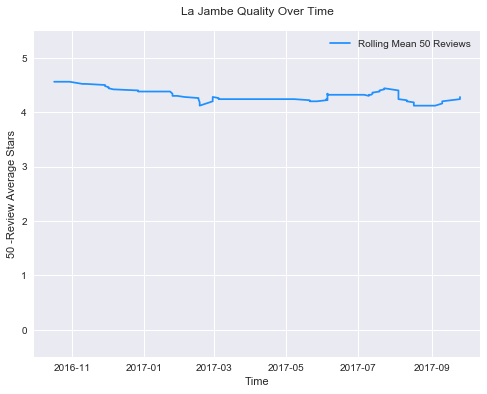

In [148]:
plot_rest_quality('La Jambe', 50)

In [149]:
# vinoteca performance over time
def plot_rest_quality(rest_name, n_reviews):
    fig = plt.figure(figsize=(8, 6))
    plt.plot(ts.sort_values(by='date')[ts.sort_values(by='date').rest_name == rest_name].stars.rolling(window=n_reviews,center=False).mean(), label='Rolling Mean %d Reviews' %n_reviews, color='dodgerblue')
    plt.ylim(-0.5,5.5)
    plt.legend(loc='best')
    plt.title('%s Quality Over Time'%rest_name, y=1.03)
    plt.ylabel('%d -Review Average Stars'%n_reviews)
    plt.xlabel('Time')

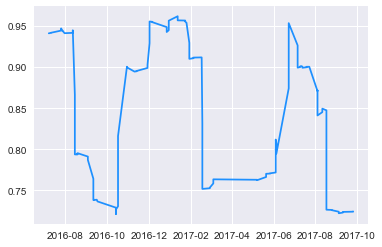

In [150]:
plt.plot(ts.sort_values(by='date')[ts.sort_values(by='date').rest_name == 'La Jambe'].sentiment.rolling(window=20,center=False).mean(), label='Rolling Mean 50 Reviews',  color='dodgerblue')




In [151]:
# vinoteca performance over time
def plot_stars_and_sent(rest_name, n_reviews):
    fig = plt.figure(figsize=(8, 6))
    plt.plot(ts.sort_values(by='date')[ts.sort_values(by='date').rest_name == rest_name][['stars', 'sentiment']].rolling(window=n_reviews,center=False).mean(), label='Rolling Mean %d Reviews' %n_reviews)
    plt.ylim(-0.5,5.5)
    plt.legend(loc='best')
    plt.title('%s Quality Over Time'%rest_name, y=1.03)
    plt.ylabel('%d -Review Average Stars'%n_reviews)
    plt.xlabel('Time')

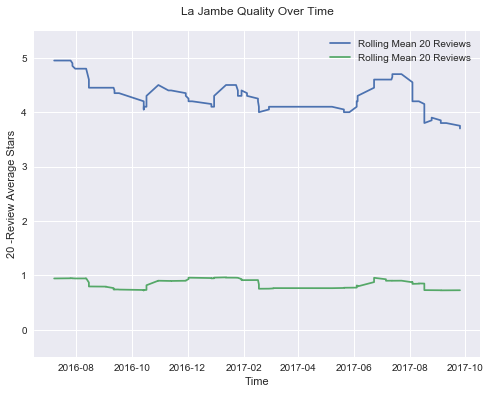

In [152]:
plot_stars_and_sent('La Jambe', 20)

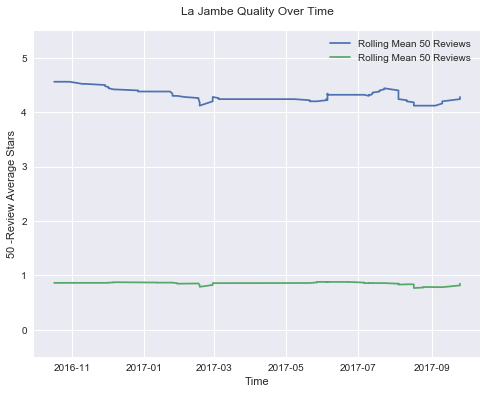

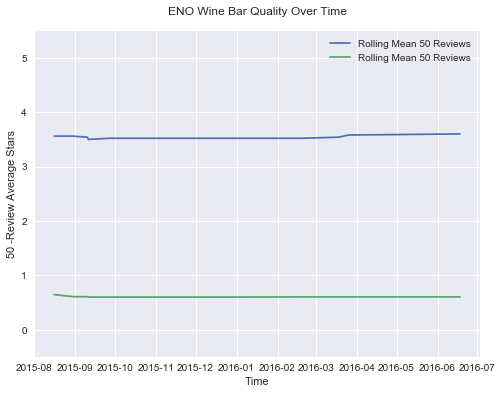

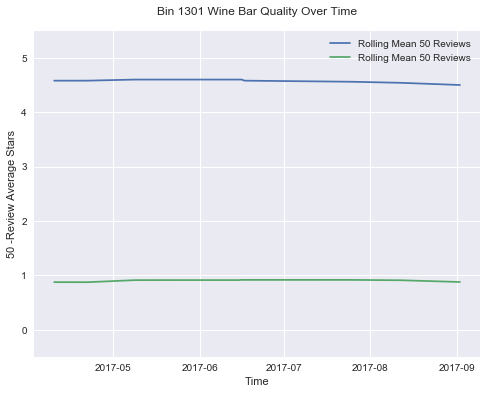

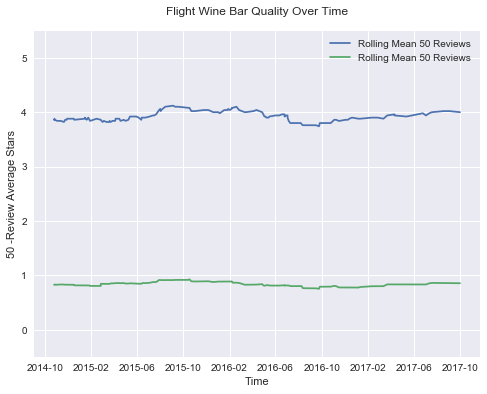

ValueError: ordinal must be >= 1

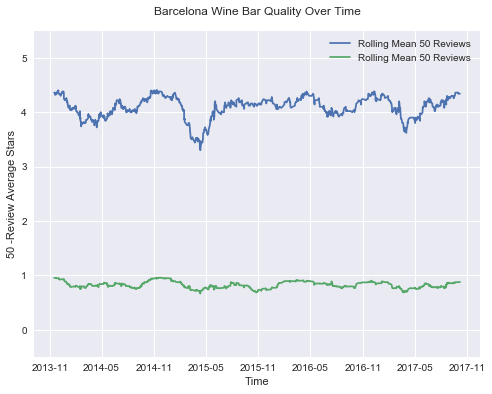

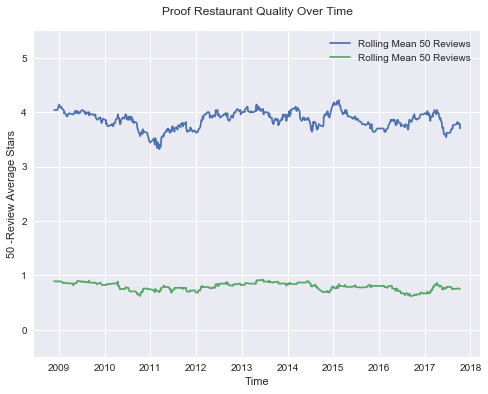

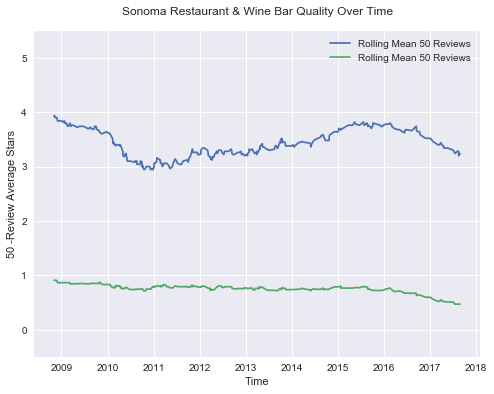

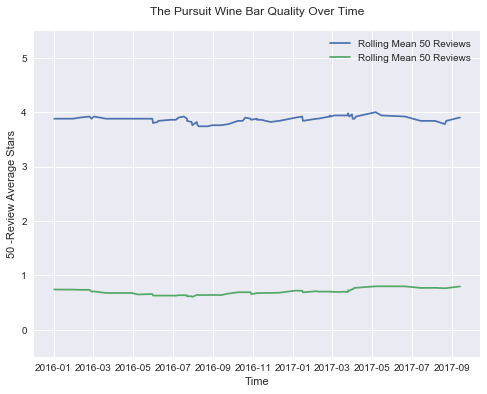

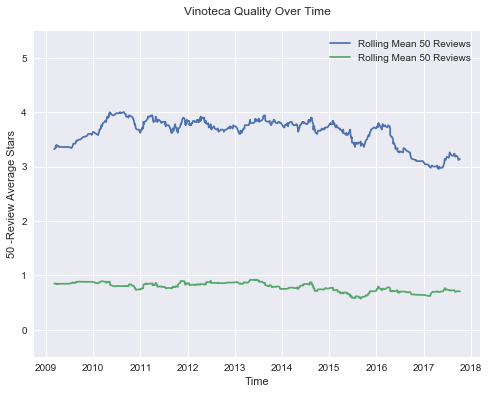

ValueError: ordinal must be >= 1

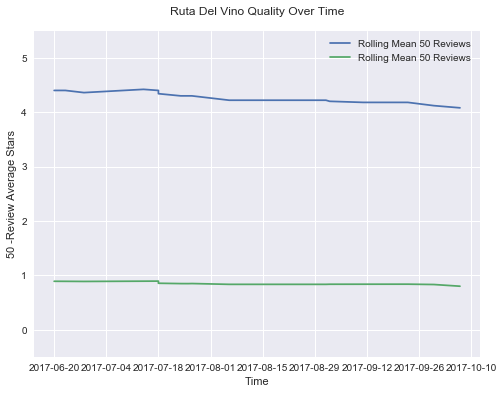

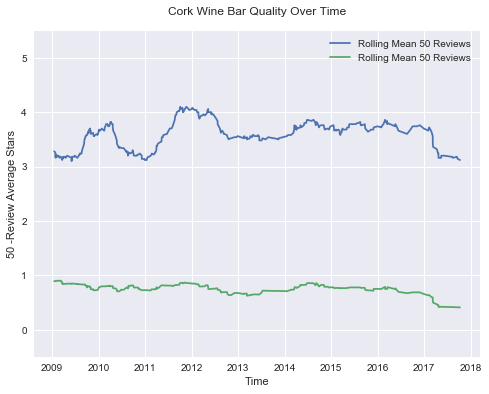

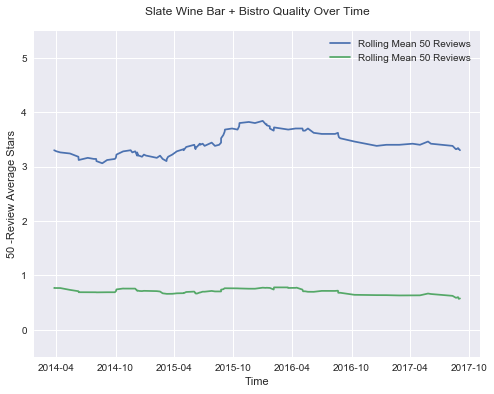

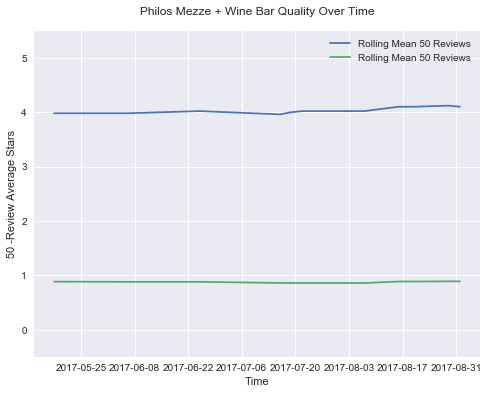

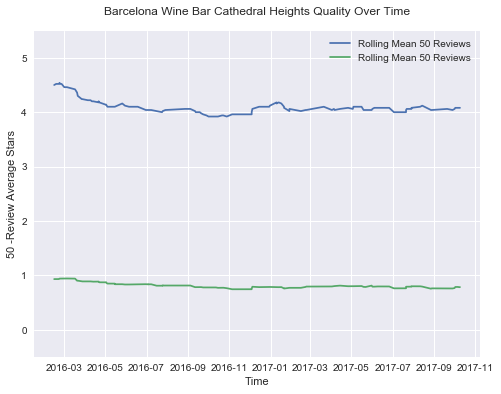

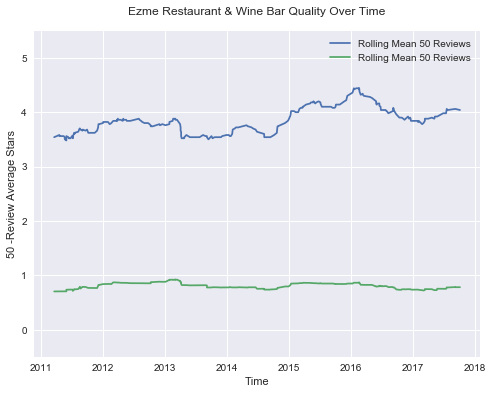

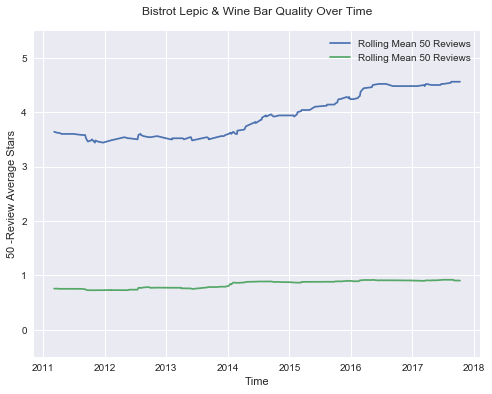

ValueError: ordinal must be >= 1

In [153]:
for rest in wine.rest_name.unique():
    plot_stars_and_sent(rest, 50)

In [154]:
wine.rest_name.unique()

array(['La Jambe', 'ENO Wine Bar', 'Bin 1301 Wine Bar', 'Flight Wine Bar',
       'Bar a Vin', 'Barcelona Wine Bar', 'Proof Restaurant',
       'Sonoma Restaurant & Wine Bar', 'The Pursuit Wine Bar', 'Vinoteca',
       'Tyber Creek Wine Bar & Kitchen', 'Ruta Del Vino', 'Cork Wine Bar',
       'Slate Wine Bar + Bistro', 'Philos Mezze + Wine Bar',
       'Barcelona Wine Bar Cathedral Heights',
       'Ezme Restaurant & Wine Bar', 'Bistrot Lepic & Wine Bar',
       'Maxwell Park'], dtype=object)

In [158]:
wine.head()

,Unnamed: 0,rest_name,username,review,stars,date,location,repeat,dmv,sentiment
0,0,La Jambe,/user_details?userid=GBjdziANdkk29jjwOBj5ow,This review is massively overdue (I don't writ...,5,8/25/2017,"Washington, DC",False,True,0.9854
1,1,La Jambe,/user_details?userid=X3Ki2Z6JTn9gbuz23NO3kg,My friends and I were looking for a good happy...,4,9/25/2017,"Washington, DC",False,True,0.9936
2,2,La Jambe,/user_details?userid=dOYJX2FBw5FXDBwXZZoq7A,Elegant and intimate - La Jambe has an unexpec...,4,8/11/2017,"Washington, DC",False,True,0.9877
3,3,La Jambe,/user_details?userid=ZaJ6zPDAc7YaDTE2QEBGPA,This place is really special. If your in the a...,5,7/23/2017,"Red Bank, NJ",False,False,0.9804
4,4,La Jambe,/user_details?userid=mz8Q8yEOkgjaISIqzUSHLg,Hooray for happy hour! $5 for delicious wines?...,4,7/10/2017,"Washington, DC",False,True,0.9913


In [178]:
# create a function that return 1 if stars is 4,5 and 0 if stars is 1,2,3

# define good review as 4,5 stars
# define bad review as 1,2,3

# input: number of stars for a restaurant
# define the bad as 1,2,3
# check if input is in "bad"
# if input is in bad, return 0
# if input is not in bad, return 1

def is_good(stars):
    bad = [1,2,3]
    good = [4,5]
    if stars in bad:
        return 0
    elif stars in good:
        return 1
    else:
        return 'NA'

In [179]:
is_good(10)

'NA'

In [181]:
# use that function and a .apply statement to create a new column 'is_good' in the dataframe
wine['is_good'] = wine.stars.apply(is_good)

In [185]:
wine[wine.is_good == 1].shape

(3505, 11)

In [186]:
wine[wine.is_good == 0].shape

(1429, 11)

## Build a model that predicts if a given review is good or bad

Given the review text, is this review a five or one star review?

In [188]:
wine.is_good.value_counts()

1    3505
0    1429
Name: is_good, dtype: int64

In [192]:
# define X and y
X = wine.review
y = wine.is_good

# split the new DataFrame into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [193]:
vect = CountVectorizer(ngram_range=(1, 2), stop_words='english', min_df=2)

In [194]:
# use vectorizer created above to create document-term matrices from X_train and X_test
X_train_dtm = vect.fit_transform(X_train)
X_test_dtm = vect.transform(X_test)

In [204]:
# establish null accuracy
y_test_binary = np.where(y_test==0, 1, 0)
null_accuracy = max(y_test_binary.mean(), 1 - y_test_binary.mean())
print(null_accuracy)

0.69773095624


In [205]:
# use Naive Bayes to predict term
nb = MultinomialNB()
nb.fit(X_train_dtm, y_train)
y_pred_class = nb.predict(X_test_dtm)

# calculate accuracy
print(metrics.accuracy_score(y_test, y_pred_class))
print(metrics.accuracy_score(y_test, y_pred_class) - null_accuracy)

0.856564019449
0.158833063209


In [ ]:
# SUPER SLOWLY and lazily going to check every parameter for an SVM on my text data
clf = svm.SVC()
gamma_range = 10.**np.arange(-5, 2)
C_range = 10.**np.arange(-2, 3)
kernel_range = ['rbf', 'sigmoid', 'linear', 'poly']
param_grid = dict(gamma=gamma_range, C=C_range, kernel=kernel_range)
grid = GridSearchCV(clf, param_grid, cv=10, scoring='accuracy')
grid.fit(X_train_dtm, y_train)

In [ ]:
# what was best?
print grid.best_score_
print grid.best_params_
print grid.best_estimator_

In [ ]:
# use logistic regression, default params
logreg = linear_model.LogisticRegression()
logreg.fit(X_train_dtm, y_train)
y_pred_class = logreg.predict(X_test_dtm)

# calculate accuracy
print(metrics.accuracy_score(y_test, y_pred_class))
print(metrics.accuracy_score(y_test, y_pred_class) - null_accuracy)

In [ ]:
rf_grid = RandomForestClassifier(random_state=99, n_jobs=50)
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth' : [None,2,5,8],
    'max_features' : ['auto', 'sqrt', 'log2'],
    'class_weight' : ['balanced', None]
}

In [ ]:
#Instantiate grid search.
grid = GridSearchCV(rf_grid, param_grid, cv=5, scoring='accuracy')

#Fit the grid search to X, and y.
grid.fit(X_train_dtm, y_train)

In [ ]:
#Store the best parameters in a variable.
params = grid.best_params_
print "Best score =", grid.best_score_
print params

In [ ]:
#Run Random Forest on the data.
rf = RandomForestClassifier(**params)
rf_model = rf.fit(X_train_dtm, y_train)
y_pred = rf.predict(X_test_dtm)

print "RandomForest Cross_Val Score:\t", cross_val_score(rf, X_train_dtm, y_train, cv=5).mean()
print "Train/Test RandomForest Score:\t", rf.score(X_test_dtm, y_test)

In [ ]:
# create dataframe showing feature importances of rf
df_features = pd.DataFrame(columns=['Features', 'Importance (Gini Index)'])
df_features['Features'] = columns=vect.get_feature_names()
df_features['Importance (Gini Index)'] = rf.feature_importances_
df_features.sort_values('Importance (Gini Index)', ascending=False, inplace=True)

In [ ]:
df_features.head(15)

In [ ]:
# plot most important features
df_features.head(15).plot(kind='bar', x='Features', color='dodgerblue')
plt.ylabel('Gini Index')
plt.xlabel('')
plt.title("Most Distinguishing Words Between Good Yelp Reviews and Bad Yelp Reviews", y=1.03)
#plt.savefig("./graphs/rf-feature-importance.png", dpi=300, bbox_inches='tight')